<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/04_SARIMA_forecasting_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA 백테스트 (R / Colab)
**4가지 예측 방식**으로 SARIMA를 실행합니다.

- **Full-sample (final fit)**: 전체 표본으로 최종 적합 → 미래 *h*일 예측 (평가용 X)
- **Fixed-origin (single-origin / holdout)**: 80% 학습으로 한 번 적합 → 남은 전구간을 한 번에 예측
- **Rolling-origin + Rolling window**: 고정 창 길이 *W*로 매 스텝 재적합 & 1-step 예측
- **Rolling-origin + Expanding window (recursive)**: 누적 창으로 매 스텝 재적합 & 1-step 예측

> 모델은 **로그-가격**에 대해 **SARIMA**를 적합하고, 예측은 **가격 스케일**로 역변환하여 평가합니다.

In [1]:
# 패키지 설치 (필요 시 한 번만 실행)
pkgs <- c("quantmod", "forecast", "ggplot2", "dplyr", "tibble", "lubridate", "scales", "tidyr")
to_install <- pkgs[!sapply(pkgs, requireNamespace, quietly = TRUE)]
if (length(to_install) > 0) install.packages(to_install, repos = "https://cloud.r-project.org")

# 로드
library(quantmod)
library(forecast)
library(ggplot2)
library(dplyr)
library(tibble)
library(lubridate)
library(scales)
library(tidyr)

# 그래프 크기/해상도 (Colab/IRkernel)
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

theme_set(theme_minimal(base_size = 14))

# 경고는 과도한 것만 억제
options(warn = 0)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘quadprog’, ‘xts’, ‘zoo’, ‘TTR’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                         

In [2]:
# ===========================
# 1) 데이터 로드
# ===========================
symbol     <- "TSLA"
start_date <- "2022-01-01"
end_date   <- "2024-01-01"

xt <- suppressWarnings(getSymbols(symbol, from = start_date, to = end_date, auto.assign = FALSE, src = "yahoo"))
df <- tibble(
  Date  = index(xt),
  Close = as.numeric(Cl(xt))
) %>% tidyr::drop_na()

# 로그-가격
df <- df %>% mutate(LogClose = log(Close))

cat(sprintf("%s: %d obs | %s ~ %s\n",
            symbol, nrow(df), as.character(df$Date[1]), as.character(df$Date[nrow(df)])))

TSLA: 501 obs | 2022-01-03 ~ 2023-12-29


In [3]:
# ===========================
# 2) 분할 & 유틸 함수
# ===========================
set.seed(42)
n <- nrow(df)
n_train <- floor(0.8 * n)

train_df <- df[1:n_train, ]
test_df  <- df[(n_train+1):n, ]

yP_train <- train_df$Close
yP_test  <- test_df$Close
yL_train <- train_df$LogClose
yL_test  <- test_df$LogClose

dates_train <- train_df$Date
dates_test  <- test_df$Date

# 지표
rmse <- function(a, b) sqrt(mean((a - b)^2))
mae  <- function(a, b) mean(abs(a - b))
r2   <- function(a, b) 1 - sum((a - b)^2) / sum((a - mean(a))^2)

# 안전한 auto.arima (로그-스케일, 주 5일 근사 계절)
fit_auto_sarima <- function(y_log_vec,
                            freq = 5,
                            max.p = 3, max.q = 3, max.P = 1, max.Q = 1,
                            max.d = 1, max.D = 1,
                            stepwise = TRUE) {
  y_ts <- ts(y_log_vec, frequency = freq)
  fit <- tryCatch(
    suppressWarnings(
      forecast::auto.arima(
        y_ts,
        seasonal      = TRUE,
        stepwise      = stepwise,
        approximation = FALSE,
        max.p         = max.p,
        max.q         = max.q,
        max.P         = max.P,
        max.Q         = max.Q,
        max.d         = max.d,
        max.D         = max.D,
        allowdrift    = TRUE,
        allowmean     = TRUE
      )
    ),
    error = function(e) NULL
  )
  fit
}

# 1-step 가격 예측 (입력: 가격 히스토리)
one_step_forecast_price <- function(price_hist,
                                    max.p = 3, max.q = 3, max.P = 1, max.Q = 1,
                                    max.d = 1, max.D = 1, freq = 5) {
  y_log <- log(price_hist)
  fit <- fit_auto_sarima(y_log, freq = freq, max.p = max.p, max.q = max.q,
                         max.P = max.P, max.Q = max.Q, max.d = max.d, max.D = max.D)
  last_p <- tail(price_hist, 1)
  if (is.null(fit)) return(last_p)
  pred_log <- tryCatch({
    as.numeric(forecast::forecast(fit, h = 1)$mean[1])
  }, error = function(e) NA_real_)
  if (is.na(pred_log)) return(last_p)
  as.numeric(exp(pred_log))
}

[Full] Best model: Series: y_ts  


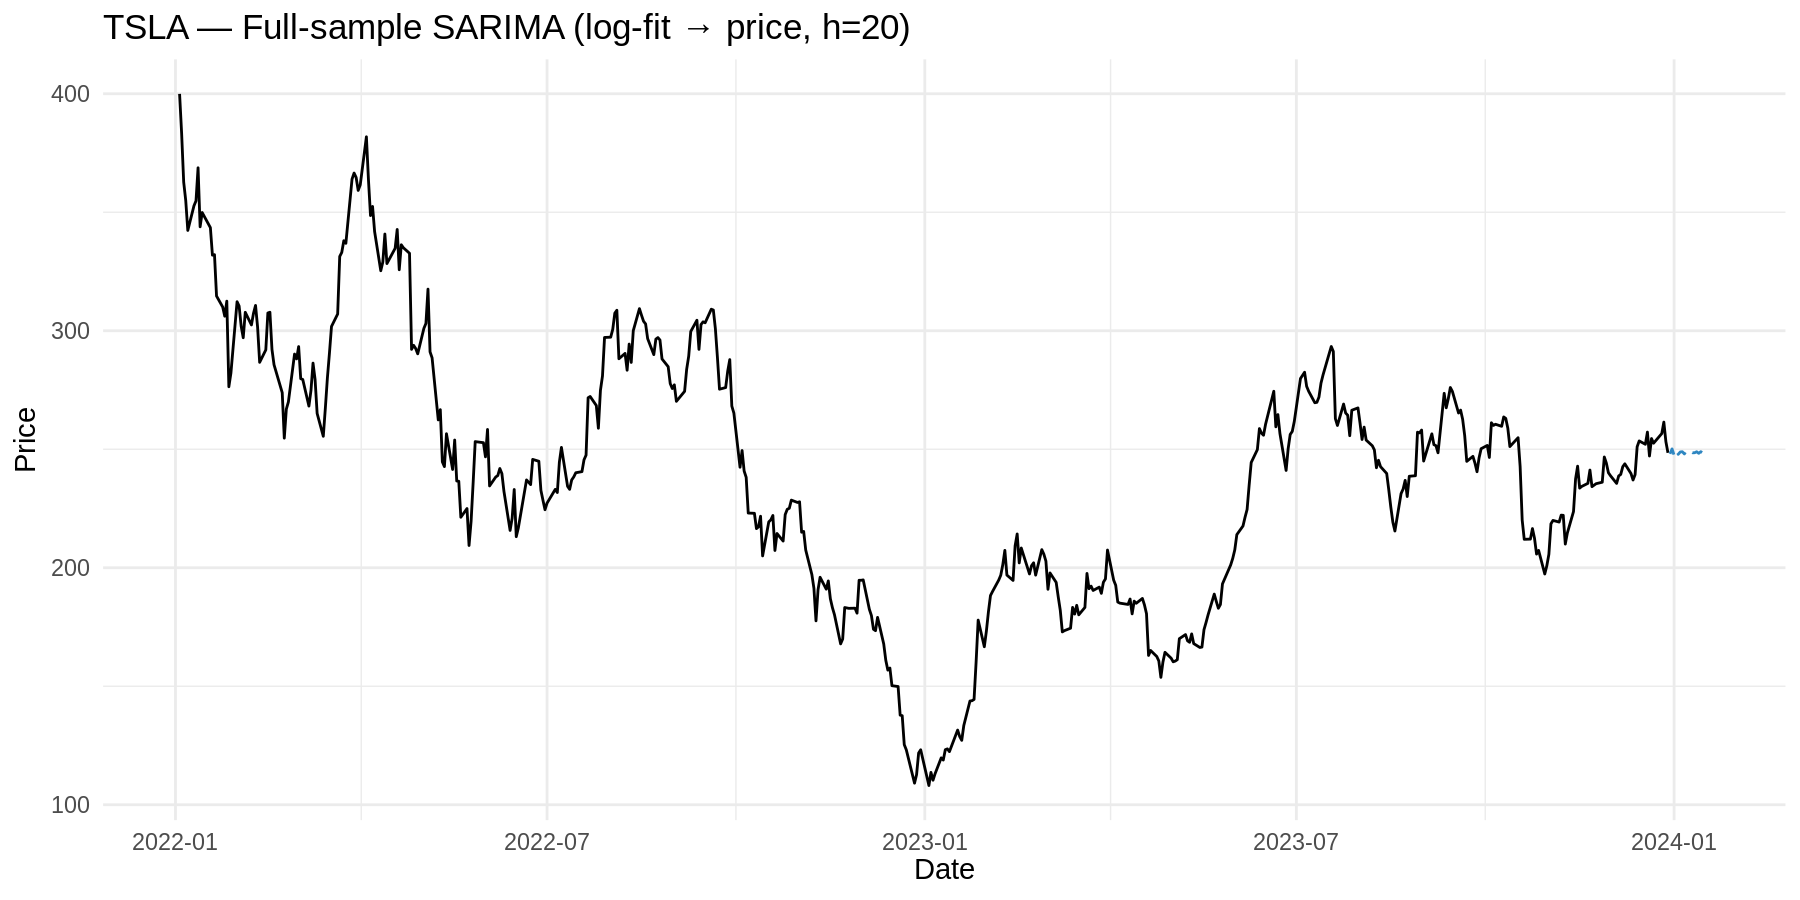

In [5]:
# ===========================
# 3) Full-sample (final fit) — 미래 h일
# ===========================
h <- 20
fit_full <- fit_auto_sarima(df$LogClose, freq = 5)
cat("[Full] Best model:", if (!is.null(fit_full)) capture.output(fit_full)[1] else "NULL", "\n")

fc_full_log <- if (!is.null(fit_full)) as.numeric(forecast::forecast(fit_full, h = h)$mean) else rep(tail(df$LogClose, 1), h)
fc_full_price <- exp(fc_full_log)

future_dates <- seq(from = df$Date[nrow(df)] + 1, by = "day", length.out = h)

ggplot() +
  geom_line(data = df, aes(Date, Close), color = "black") +
  geom_line(data = tibble(Date = future_dates, Close = fc_full_price),
            aes(Date, Close), linetype = "dashed", color = "#2E86C1") +
  labs(title = sprintf("%s — Full-sample SARIMA (log-fit → price, h=%d)", symbol, h),
       x = "Date", y = "Price")

In [6]:
# ===========================
# 4) Fixed-origin (holdout) — 한 번 적합 → 전구간 예측
# ===========================
fit_fix <- fit_auto_sarima(yL_train, freq = 5)
cat("[Fixed-origin] Best model:", if (!is.null(fit_fix)) capture.output(fit_fix)[1] else "NULL", "\n")

pred_fix_log <- if (!is.null(fit_fix)) as.numeric(forecast::forecast(fit_fix, h = length(yL_test))$mean) else rep(tail(yL_train, 1), length(yL_test))
pred_fix_price <- exp(pred_fix_log)

rmse_fix <- rmse(yP_test, pred_fix_price)
mae_fix  <- mae(yP_test, pred_fix_price)
r2_fix   <- r2(yP_test, pred_fix_price)
cat(sprintf("[Fixed-origin] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_fix, mae_fix, r2_fix))

df_fix <- tibble(Date = dates_test, Actual = yP_test, Pred = pred_fix_price)
ggplot(df_fix, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred),   color = "#2E86C1", linetype = "dashed") +
  labs(title = sprintf("%s — Fixed-origin SARIMA (log-fit → price)", symbol),
       x = "Date", y = "Price")

ERROR: Error in parse(text = input): <text>:8:17: unexpected 'else'
7: pred_fix_log <- if (!is.null(fit_fix)) as.numeric(forecast::forecast(fit_fix, h = length(yL_test))$mean)
8:                 else
                   ^


[Rolling window] RMSE=6.9950 | MAE=5.1744 | R2=0.8388


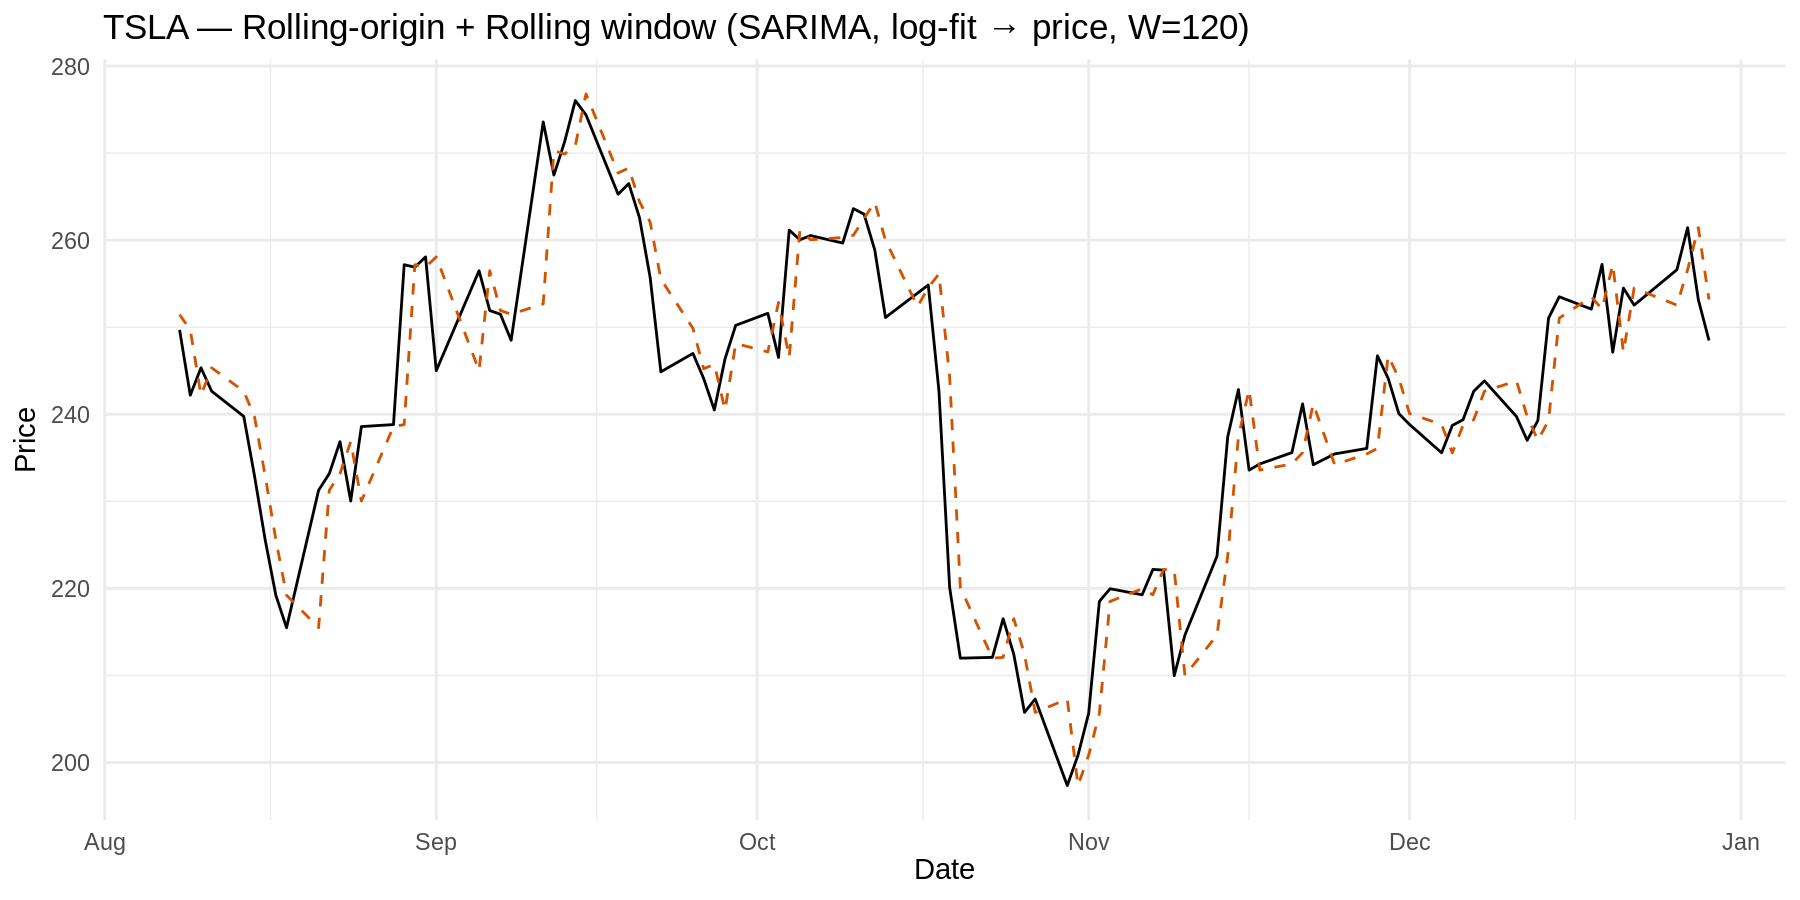

In [7]:
# ===========================
# 5) Rolling-origin + Rolling window — 1-step 워크포워드
# ===========================
W <- 120      # 창 길이
pred_roll <- rep(NA_real_, length(yP_test))
hist_price <- yP_train

for (i in seq_along(yP_test)) {
  # 윈도우
  y_win <- if (length(hist_price) >= W) tail(hist_price, W) else hist_price
  # 1-step 예측
  yhat <- one_step_forecast_price(y_win)
  pred_roll[i] <- yhat
  # 워크포워드(실제값 추가)
  hist_price <- c(hist_price, yP_test[i])
}

rmse_r <- rmse(yP_test, pred_roll)
mae_r  <- mae(yP_test, pred_roll)
r2_r   <- r2(yP_test, pred_roll)
cat(sprintf("[Rolling window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_r, mae_r, r2_r))

df_roll <- tibble(Date = dates_test, Actual = yP_test, Pred = pred_roll)
ggplot(df_roll, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred),   color = "#D35400", linetype = "dashed") +
  labs(title = sprintf("%s — Rolling-origin + Rolling window (SARIMA, log-fit → price, W=%d)", symbol, W),
       x = "Date", y = "Price")

[Expanding window] RMSE=7.0979 | MAE=5.2853 | R2=0.8341


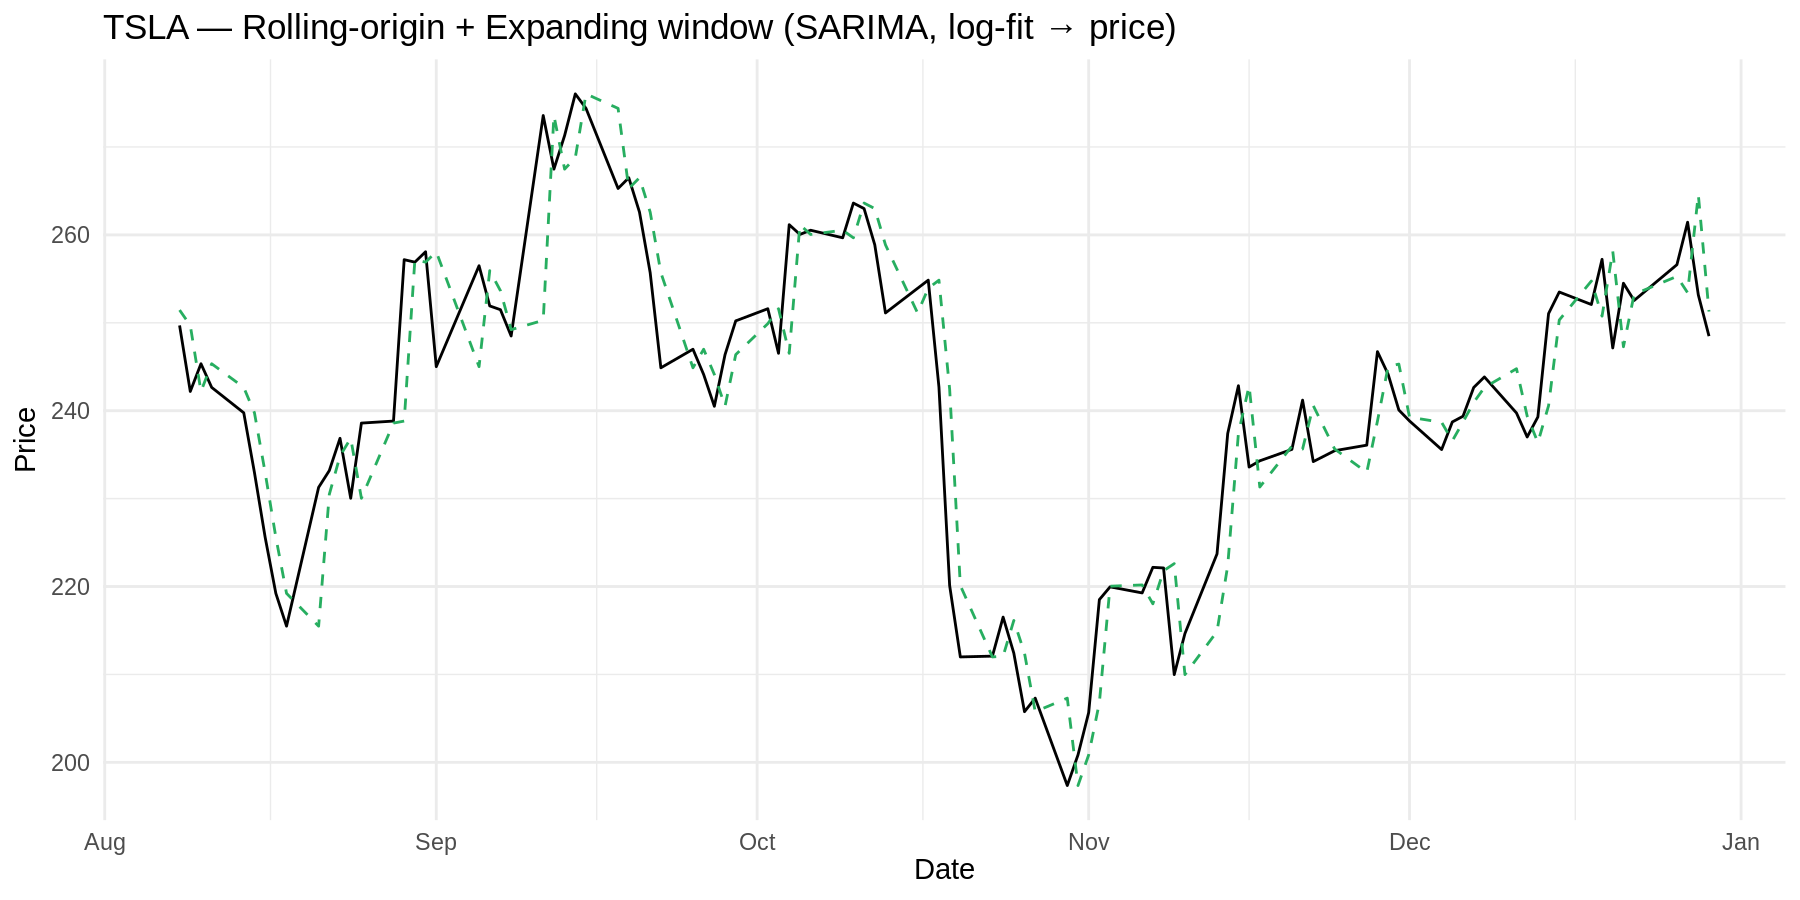

In [8]:
# ===========================
# 6) Rolling-origin + Expanding window — 1-step 워크포워드
# ===========================
pred_exp <- rep(NA_real_, length(yP_test))
hist_price <- yP_train

for (i in seq_along(yP_test)) {
  yhat <- one_step_forecast_price(hist_price)
  pred_exp[i] <- yhat
  hist_price <- c(hist_price, yP_test[i])
}

rmse_e <- rmse(yP_test, pred_exp)
mae_e  <- mae(yP_test, pred_exp)
r2_e   <- r2(yP_test, pred_exp)
cat(sprintf("[Expanding window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_e, mae_e, r2_e))

df_exp <- tibble(Date = dates_test, Actual = yP_test, Pred = pred_exp)
ggplot(df_exp, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred),   color = "#27AE60", linetype = "dashed") +
  labs(title = sprintf("%s — Rolling-origin + Expanding window (SARIMA, log-fit → price)", symbol),
       x = "Date", y = "Price")

Fixed-origin best model (log-price): Series: yL_train  
[Fixed-origin] RMSE=19.9963 | MAE=15.2640 | R2=-0.3170
# A tibble: 3 × 4
  Method            RMSE   MAE     R2
  <chr>            <dbl> <dbl>  <dbl>
1 Rolling window    6.99  5.17  0.839
2 Expanding window  7.10  5.29  0.834
3 Fixed-origin     20.0  15.3  -0.317


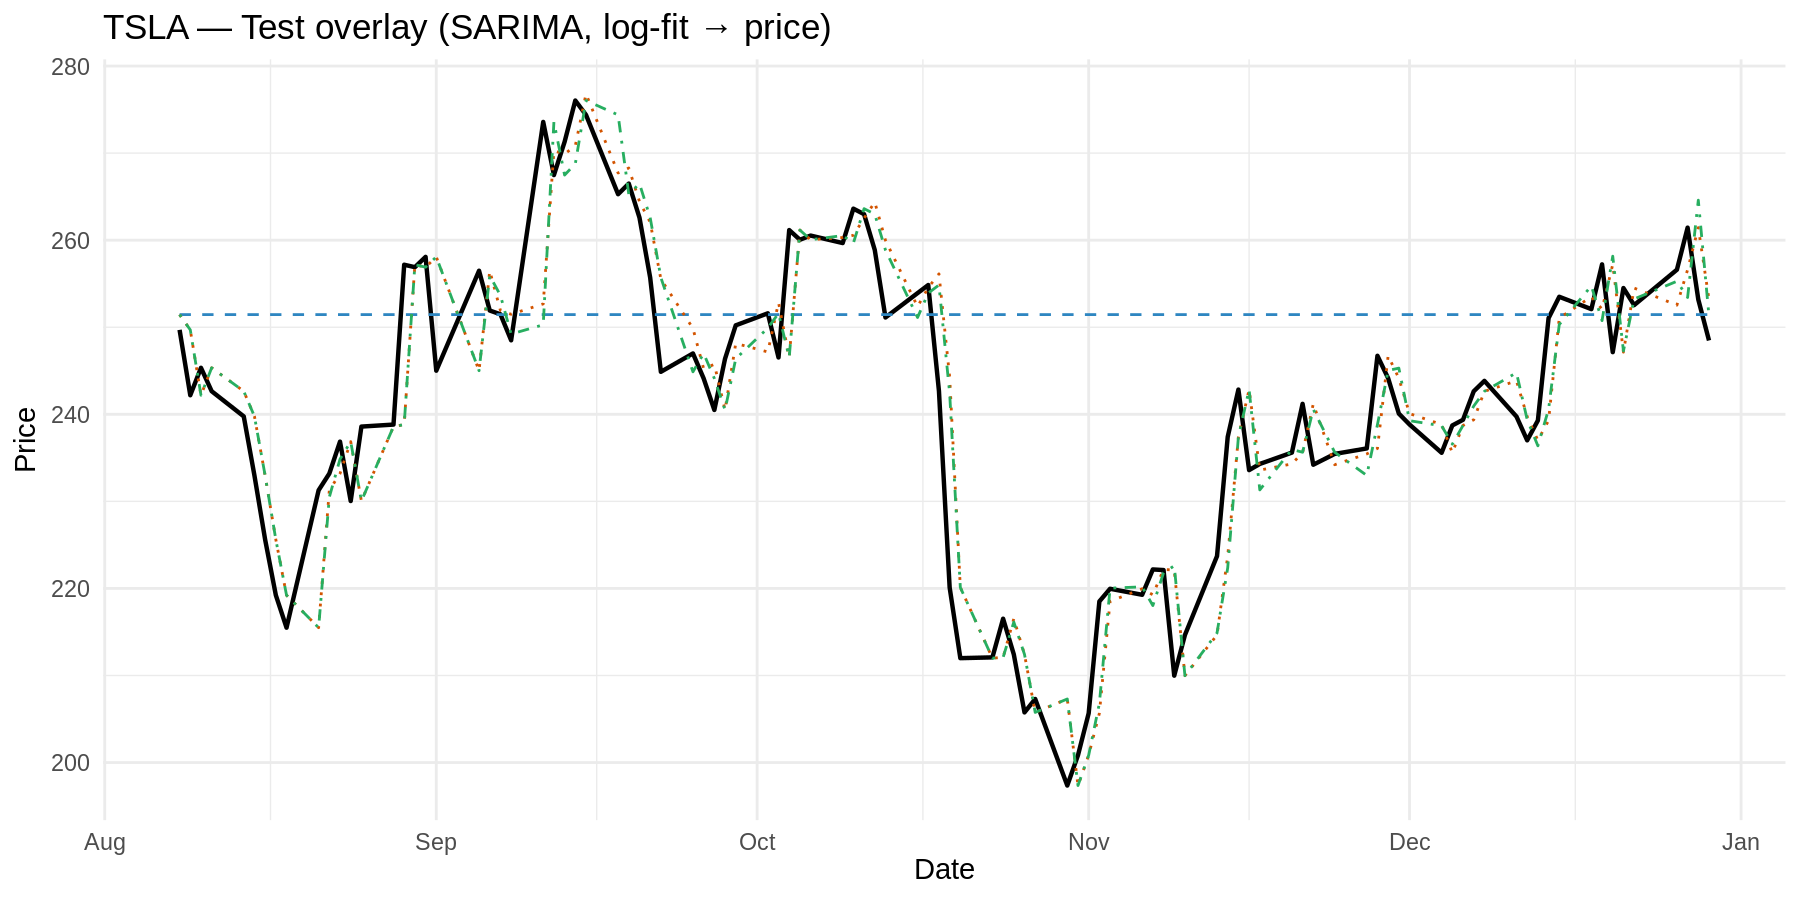

In [14]:
# ── 그림 크기(Colab/R) ───────────────────────────────────────────────
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

suppressPackageStartupMessages({
  library(forecast)
  library(ggplot2)
  library(dplyr)
})

# ── 지표 함수 ────────────────────────────────────────────────────────
if (!exists("rmse")) rmse <- function(a, b) sqrt(mean((a - b)^2, na.rm = TRUE))
if (!exists("mae"))  mae  <- function(a, b) mean(abs(a - b), na.rm = TRUE)
if (!exists("r2"))   r2   <- function(a, b) {
  ss_res <- sum((a - b)^2, na.rm = TRUE)
  ss_tot <- sum((a - mean(a, na.rm = TRUE))^2, na.rm = TRUE)
  1 - ss_res / ss_tot
}

# ── 데이터 준비(있으면 재사용, 없으면 다운로드) ────────────────────
if (!exists("px")) {
  suppressPackageStartupMessages(library(quantmod))
  symbol <- "TSLA"
  xt <- suppressWarnings(getSymbols(symbol, src = "yahoo",
                                    from = "2022-01-01", to = "2024-01-01",
                                    auto.assign = FALSE))
  px <- data.frame(Date = index(xt), Close = as.numeric(Cl(xt)))
}

px <- px %>% select(Date, Close) %>% tidyr::drop_na()
px$Date <- as.Date(px$Date)

yP    <- px$Close                   # price level
yL    <- log(yP)                    # log-price
dates <- px$Date

n        <- length(yP)
train_sz <- floor(n * 0.8)

yP_train <- yP[1:train_sz]
yP_test  <- yP[(train_sz+1):n]

yL_train <- yL[1:train_sz]
yL_test  <- yL[(train_sz+1):n]

dates_train <- dates[1:train_sz]
dates_test  <- dates[(train_sz+1):n]

if (!exists("symbol")) symbol <- "TSLA"

# ── Fixed-origin: log-price에 auto.arima 적합(경고 최소화) ───────────
suppressWarnings({
  fit_fix <- auto.arima(
    y = yL_train,
    seasonal = FALSE,    # 일일 주가: 계절성 비활성 권장
    stepwise = TRUE, approximation = FALSE,
    max.d = 1            # 과도한 차분 억제 → 안정적
  )
})

cat("Fixed-origin best model (log-price):", capture.output(fit_fix)[1], "\n")

# 테스트 전구간 예측(로그 → 가격 스케일 역변환)
pred_fix <- exp(as.numeric(forecast(fit_fix, h = length(yL_test))$mean))

# ── 지표(가격 스케일) ────────────────────────────────────────────────
rmse_fix <- rmse(yP_test, pred_fix)
mae_fix  <- mae(yP_test, pred_fix)
r2_fix   <- r2 (yP_test, pred_fix)

cat(sprintf("[Fixed-origin] RMSE=%.4f | MAE=%.4f | R2=%.4f\n",
            rmse_fix, mae_fix, r2_fix))

# ===========================
# 7) 요약 표 & 오버레이
# ===========================
summary_tbl <- tibble::tibble(
  Method = c("Fixed-origin", "Rolling window", "Expanding window"),
  RMSE   = c(rmse_fix, rmse_r, rmse_e),
  MAE    = c(mae_fix,  mae_r,  mae_e),
  R2     = c(r2_fix,   r2_r,   r2_e)
) %>% arrange(RMSE)

print(summary_tbl)

ggplot() +
  geom_line(data = tibble(Date = dates_test, Price = yP_test), aes(Date, Price), color = "black", linewidth = 1) +
  geom_line(data = tibble(Date = dates_test, Price = exp(as.numeric(forecast::forecast(fit_fix, h = length(yL_test))$mean))),
            aes(Date, Price), linetype = "dashed", color = "#2E86C1") +
  geom_line(data = tibble(Date = dates_test, Price = pred_roll), aes(Date, Price), linetype = "dotted", color = "#D35400") +
  geom_line(data = tibble(Date = dates_test, Price = pred_exp),  aes(Date, Price), linetype = "dotdash", color = "#27AE60") +
  labs(title = sprintf("%s — Test overlay (SARIMA, log-fit → price)", symbol),
       x = "Date", y = "Price")